In [ ]:
!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 839ms/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 72.6322 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 1s 64ms/step - loss: 71.4605 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 70.0359 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 1s 63ms/step - loss: 68.2689 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 1s 74ms/step - loss: 66.4883 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 1s 71ms/step - loss: 64.2616 - mae: 64.7354
Epoch 8/100
8/8 [==============================] - 1s 68ms/step - loss: 62.0457 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 1s 96ms/step - loss: 59.3746 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 1s 83ms/step - loss: 56.3313 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 104ms/step - loss: 18.6782 - mae: 18.8123
Epoch 87/100
8/8 [==============================] - 1s 99ms/step - loss: 16.9267 - mae: 16.8209
Epoch 88/100
8/8 [==============================] - 1s 85ms/step - loss: 11.9305 - mae: 12.5103
Epoch 89/100
8/8 [==============================] - 1s 95ms/step - loss: 11.2024 - mae: 11.7372
Epoch 90/100
8/8 [==============================] - 1s 75ms/step - loss: 25.3754 - mae: 25.4919
Epoch 91/100
8/8 [==============================] - 1s 80ms/step - loss: 18.9862 - mae: 20.2349
Epoch 92/100
8/8 [==============================] - 1s 77ms/step - loss: 23.6025 - mae: 23.9255
Epoch 93/100
8/8 [==============================] - 1s 74ms/step - loss: 15.0457 - mae: 15.2531
Epoch 94/100
8/8 [==============================] - 1s 72ms/step - loss: 15.3614 - mae: 16.1642
Epoch 95/100
8/8 [==============================] - 1s 74ms/step - loss: 16.9640 - mae: 17.7036
Epoch 96/100
8/8 [==============================] - 

[1e-08, 0.0001, 0, 30]

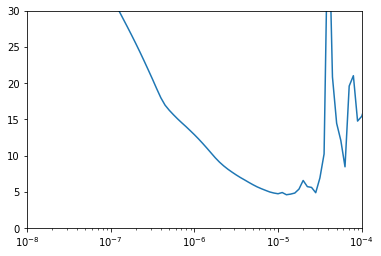

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
61/61 [==============================] - 5s 74ms/step - loss: 14.3561 - mae: 14.8810
Epoch 2/500
61/61 [==============================] - 2s 26ms/step - loss: 6.7434 - mae: 7.2288
Epoch 3/500
61/61 [==============================] - 2s 26ms/step - loss: 5.8957 - mae: 6.3724
Epoch 4/500
61/61 [==============================] - 2s 26ms/step - loss: 5.4559 - mae: 5.9363
Epoch 5/500
61/61 [==============================] - 2s 29ms/step - loss: 5.3584 - mae: 5.8323
Epoch 6/500
61/61 [==============================] - 2s 28ms/step - loss: 5.1366 - mae: 5.6142
Epoch 7/500
61/61 [==============================] - 2s 26ms/step - loss: 4.9856 - mae: 5.4667
Epoch 8/500
61/61 [==============================] - 2s 26ms/step - loss: 4.9236 - mae: 5.4023
Epoch 9/500
61/61 [==============================] - 2s 26ms/step - loss: 4.8418 - mae: 5.3156
Epoch 10/500
61/61 [==============================] - 2s 30ms/step - loss: 4.8824 - mae: 5.3573
Epoch 11/500
61/61 [===========================

61/61 [==============================] - 2s 34ms/step - loss: 4.2396 - mae: 4.7147
Epoch 87/500
61/61 [==============================] - 2s 33ms/step - loss: 4.1811 - mae: 4.6538: 2s - 
Epoch 88/500
61/61 [==============================] - 2s 30ms/step - loss: 4.1816 - mae: 4.6568
Epoch 89/500
61/61 [==============================] - 2s 30ms/step - loss: 4.1118 - mae: 4.5802
Epoch 90/500
61/61 [==============================] - 2s 30ms/step - loss: 4.3040 - mae: 4.7793
Epoch 91/500
61/61 [==============================] - 2s 26ms/step - loss: 4.1581 - mae: 4.6303
Epoch 92/500
61/61 [==============================] - 2s 27ms/step - loss: 4.1257 - mae: 4.5966
Epoch 93/500
61/61 [==============================] - 2s 30ms/step - loss: 4.1427 - mae: 4.6186
Epoch 94/500
61/61 [==============================] - 2s 29ms/step - loss: 4.1367 - mae: 4.6125
Epoch 95/500
61/61 [==============================] - 2s 26ms/step - loss: 4.1395 - mae: 4.6146
Epoch 96/500
61/61 [==========================

61/61 [==============================] - 2s 32ms/step - loss: 4.0719 - mae: 4.5440
Epoch 170/500
61/61 [==============================] - 2s 35ms/step - loss: 4.0691 - mae: 4.5452
Epoch 171/500
61/61 [==============================] - 2s 31ms/step - loss: 4.0016 - mae: 4.4791
Epoch 172/500
61/61 [==============================] - 2s 29ms/step - loss: 4.0032 - mae: 4.4729
Epoch 173/500
61/61 [==============================] - 2s 30ms/step - loss: 4.0987 - mae: 4.5730
Epoch 174/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0329 - mae: 4.5072
Epoch 175/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0024 - mae: 4.4750
Epoch 176/500
61/61 [==============================] - 1s 24ms/step - loss: 3.9952 - mae: 4.4689
Epoch 177/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0189 - mae: 4.4923
Epoch 178/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0010 - mae: 4.4768
Epoch 179/500
61/61 [=======================

61/61 [==============================] - 1s 23ms/step - loss: 3.9506 - mae: 4.4240
Epoch 254/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0189 - mae: 4.4953
Epoch 255/500
61/61 [==============================] - 1s 24ms/step - loss: 3.9752 - mae: 4.4480
Epoch 256/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0549 - mae: 4.5291
Epoch 257/500
61/61 [==============================] - 1s 24ms/step - loss: 4.0913 - mae: 4.5623
Epoch 258/500
61/61 [==============================] - 2s 25ms/step - loss: 3.9696 - mae: 4.4423
Epoch 259/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9314 - mae: 4.4043
Epoch 260/500
61/61 [==============================] - 1s 24ms/step - loss: 3.9973 - mae: 4.4685
Epoch 261/500
61/61 [==============================] - 2s 26ms/step - loss: 4.0005 - mae: 4.4748
Epoch 262/500
61/61 [==============================] - 1s 23ms/step - loss: 3.9476 - mae: 4.4174
Epoch 263/500
61/61 [=======================

61/61 [==============================] - 2s 26ms/step - loss: 3.9252 - mae: 4.4002
Epoch 337/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9735 - mae: 4.4447
Epoch 338/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9081 - mae: 4.3824
Epoch 339/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9193 - mae: 4.3893
Epoch 340/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9149 - mae: 4.3860
Epoch 341/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9313 - mae: 4.4033
Epoch 342/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9088 - mae: 4.3776
Epoch 343/500
61/61 [==============================] - 2s 27ms/step - loss: 3.9117 - mae: 4.3836
Epoch 344/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9246 - mae: 4.3969
Epoch 345/500
61/61 [==============================] - 2s 26ms/step - loss: 3.9132 - mae: 4.3844
Epoch 346/500
61/61 [=======================

61/61 [==============================] - 1s 23ms/step - loss: 3.9403 - mae: 4.4104
Epoch 421/500
61/61 [==============================] - 1s 24ms/step - loss: 3.9102 - mae: 4.3794
Epoch 422/500
61/61 [==============================] - 2s 25ms/step - loss: 3.8751 - mae: 4.3474
Epoch 423/500
61/61 [==============================] - 2s 25ms/step - loss: 3.9293 - mae: 4.4009
Epoch 424/500
61/61 [==============================] - 1s 24ms/step - loss: 3.8903 - mae: 4.3609
Epoch 425/500
61/61 [==============================] - 1s 24ms/step - loss: 3.8829 - mae: 4.3554
Epoch 426/500
61/61 [==============================] - 2s 25ms/step - loss: 3.9395 - mae: 4.4077
Epoch 427/500
61/61 [==============================] - 2s 25ms/step - loss: 3.8845 - mae: 4.3548
Epoch 428/500
61/61 [==============================] - 2s 25ms/step - loss: 3.9609 - mae: 4.4306
Epoch 429/500
61/61 [==============================] - 1s 24ms/step - loss: 3.8636 - mae: 4.3324
Epoch 430/500
61/61 [=======================

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

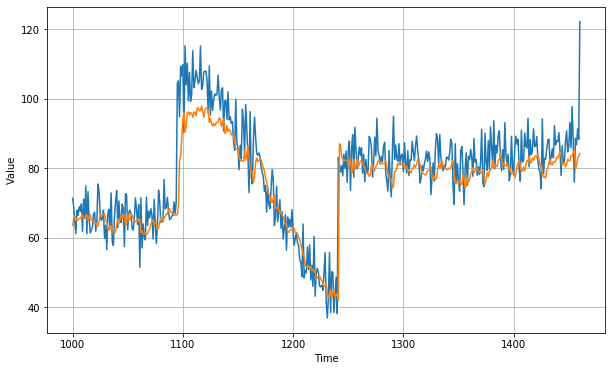

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0133257

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.532126

<Figure size 432x288 with 0 Axes>

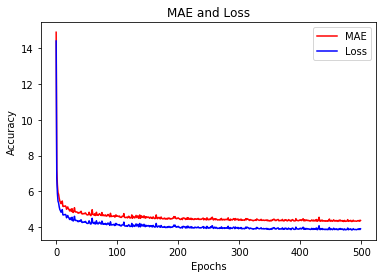

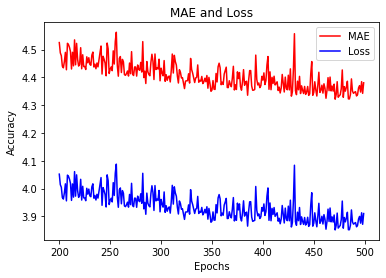

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()